<a href="https://colab.research.google.com/github/VenkyNunna/Tooth_repo/blob/main/OralVis_YOLO_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# run in a code cell (prefix ! for shell)
!pip install -q --upgrade pip
!pip install -q ultralytics gdown opencv-python-headless matplotlib pandas scikit-learn tqdm pyyaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.6 MB/s eta 0:00:00


In [3]:
# change path if your zip is elsewhere in Drive
!unzip -q /content/drive/MyDrive/ToothNumber_TaskDataset.zip -d /content/oralvis_dataset
# show top-level files/folders
!ls -lah /content/oralvis_dataset | sed -n '1,200p'


total 88K
drwxr-xr-x 4 root root 4.0K Aug 28 09:33 .
drwxr-xr-x 1 root root 4.0K Aug 28 09:33 ..
drwx------ 2 root root  36K Aug 26 07:02 images
drwx------ 2 root root  40K Aug 26 07:02 labels


In [4]:
!find /content/oralvis_dataset -maxdepth 2 -type f | sed -n '1,200p'


/content/oralvis_dataset/images/cate8-00305_jpg.rf.8c8278b3305348748e46af2f33e2e538.jpg
/content/oralvis_dataset/images/cate5-00108_jpg.rf.996d16807e3c8734f22dd2e43b6ac2d9.jpg
/content/oralvis_dataset/images/cate8-00257_jpg.rf.2f8f9d5cbd873f542d90bcc57bceae33.jpg
/content/oralvis_dataset/images/cate10-00108_jpg.rf.912ca1f68f0307534ff59a071ed40224.jpg
/content/oralvis_dataset/images/cate2-00038_jpg.rf.b4ef5151bae96f4de7f613fb96b7735e.jpg
/content/oralvis_dataset/images/cate8-00094_jpg.rf.c7c830a886d59fb196ffed83200754d7.jpg
/content/oralvis_dataset/images/4b9ffa7d-20250502-151642682.jpg
/content/oralvis_dataset/images/cate8-00191_jpg.rf.856a6afd259fc24434201fdf1c9b37a0.jpg
/content/oralvis_dataset/images/f1e56772-20250428-124704468.jpg
/content/oralvis_dataset/images/cate5-00049_jpg.rf.423e42bec9a39f5ce2ab5a3da4cbf2fb.jpg
/content/oralvis_dataset/images/cate8-00253_jpg.rf.00abf6ca77c6a36704e4001ed1076df3.jpg
/content/oralvis_dataset/images/cate6-00069_jpg.rf.f6d5c4f63c0be142252591ef2105

Found images: 497
Sample image: /content/oralvis_dataset/images/4a54fcae-20240808-115419598.jpg
Expect label file: /content/oralvis_dataset/images/4a54fcae-20240808-115419598.txt Exists? False


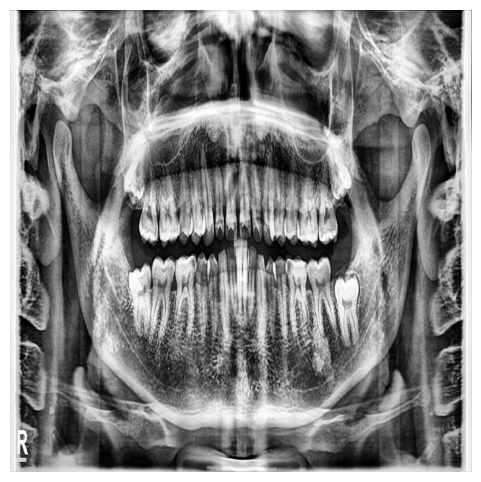

Label not found for this image.


In [5]:
import glob, random, cv2, os
from matplotlib import pyplot as plt
img_paths = glob.glob('/content/oralvis_dataset/**/*.jpg', recursive=True) + glob.glob('/content/oralvis_dataset/**/*.png', recursive=True)
img_paths = sorted(img_paths)
print("Found images:", len(img_paths))
# pick one
p = random.choice(img_paths)
print("Sample image:", p)
# corresponding label (same basename .txt)
lbl = os.path.splitext(p)[0] + '.txt'
print("Expect label file:", lbl, "Exists?", os.path.exists(lbl))
# show image
img = cv2.imread(p)
plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.show()
# print label contents if exists
if os.path.exists(lbl):
    print("Label contents (first 10 lines):")
    for i,line in enumerate(open(lbl).read().strip().splitlines()[:10]):
        print(i+1, line)
else:
    print("Label not found for this image.")


In [6]:
import glob, os
img_files = glob.glob('/content/oralvis_dataset/**/*.*', recursive=True)
img_files = [p for p in img_files if p.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff'))]
missing = []
bad_format = []
class_out_of_range = []
total_labels = 0
for im in img_files:
    lbl = os.path.splitext(im)[0] + '.txt'
    if not os.path.exists(lbl):
        missing.append(im)
    else:
        lines = [l.strip() for l in open(lbl).read().strip().splitlines() if l.strip()]
        total_labels += len(lines)
        for ln in lines:
            parts = ln.split()
            if len(parts) < 5:
                bad_format.append((lbl, ln))
            else:
                try:
                    cls = int(float(parts[0]))
                    if cls < 0 or cls > 31:
                        class_out_of_range.append((lbl, ln))
                except:
                    bad_format.append((lbl, ln))
print("Images found:", len(img_files))
print("Total label lines:", total_labels)
print("Images missing label files:", len(missing))
print("Label lines with bad format:", len(bad_format))
print("Label lines with class index out of range:", len(class_out_of_range))
# show examples
if missing: print("Example missing:", missing[:3])
if bad_format: print("Example bad format:", bad_format[:3])
if class_out_of_range: print("Example out-of-range:", class_out_of_range[:3])


Images found: 497
Total label lines: 0
Images missing label files: 497
Label lines with bad format: 0
Label lines with class index out of range: 0
Example missing: ['/content/oralvis_dataset/images/cate8-00305_jpg.rf.8c8278b3305348748e46af2f33e2e538.jpg', '/content/oralvis_dataset/images/cate5-00108_jpg.rf.996d16807e3c8734f22dd2e43b6ac2d9.jpg', '/content/oralvis_dataset/images/cate8-00257_jpg.rf.2f8f9d5cbd873f542d90bcc57bceae33.jpg']


In [7]:
import glob, os

xmls = glob.glob('/content/oralvis_dataset/**/*.xml', recursive=True)
jsons = glob.glob('/content/oralvis_dataset/**/*.json', recursive=True)

print("Found XML:", len(xmls))
print("Found JSON:", len(jsons))
print("Example XML:", xmls[:3])
print("Example JSON:", jsons[:3])


Found XML: 0
Found JSON: 0
Example XML: []
Example JSON: []


In [8]:
!ls -R /content/oralvis_dataset | head -n 200


/content/oralvis_dataset:
images
labels

/content/oralvis_dataset/images:
00147087-20240918-120248027.jpg
0337fb14-20240822-124747143.jpg
05473f26-20240924-154033777.jpg
05ff01fa-20250108-115407401.jpg
061339f1-20240911-110938655.jpg
069750f6-20240914-102814322.jpg
084c3562-20240827-154718191.jpg
0ba65172-20240821-105924223.jpg
0c4cebbe-20240813-144203674.jpg
0fcae64f-20241217-121556078.jpg
0fd502a1-20250123-111857443.jpg
103dd85b-20240831-101746682.jpg
124e696d-20240914-105651782.jpg
1459fc45-20240831-113821806.jpg
16a28cd9-20240723-113852192.jpg
18fd6ab8-20250415-143542497.jpg
1b000dc7-20240813-115604759.jpg
1c50bda9-20241231-145320490.jpg
1fc5e51d-20241219-142523942.jpg
22464331-20240919-102844605.jpg
23f1d012-20240628-115132889.jpg
26f91eeb-20240903-150428112.jpg
271041ce-20250421-112436631.jpg
2725830c-20240829-130426513.jpg
281350f8-20240813-145334040.jpg
28c54465-20240727-114541091.jpg
2b1da7b0-20240813-114403429.jpg
2d580460-20240730-115355708.jpg
2d87cff9-20240801-161145471.jp

In [9]:
import glob, os

label_files = glob.glob('/content/oralvis_dataset/labels/*.txt')
print("Total label files:", len(label_files))
print("Example file:", label_files[0])
print("--- First 10 lines of that file ---")
print("\n".join(open(label_files[0]).read().splitlines()[:10]))


Total label files: 497
Example file: /content/oralvis_dataset/labels/cate2-00014_jpg.rf.d7f786ae7e337fd90b4661215a8692fb.txt
--- First 10 lines of that file ---
31 0.165625 0.49921875 0.09140625 0.2109375
23 0.22578125 0.565625 0.1078125 0.24375
11 0.290625 0.60078125 0.1078125 0.22265625
30 0.8375 0.49921875 0.08515625 0.1984375
22 0.78046875 0.55625 0.0953125 0.225
10 0.7109375 0.59375 0.08515625 0.2375
26 0.65390625 0.62109375 0.05390625 0.2375
13 0.6171875 0.63359375 0.04765625 0.24609375
2 0.584375 0.634375 0.0640625 0.26484375
17 0.5390625 0.640625 0.02109375 0.22265625


In [10]:
import os, glob, random, shutil

SRC_IMG = "/content/oralvis_dataset/images"
SRC_LBL = "/content/oralvis_dataset/labels"
DST_ROOT = "/content/dataset"

random.seed(42)

# collect pairs
img_files = glob.glob(os.path.join(SRC_IMG, "*.jpg"))
paired = []
for im in img_files:
    base = os.path.splitext(os.path.basename(im))[0]
    lbl = os.path.join(SRC_LBL, base + ".txt")
    if os.path.exists(lbl):
        paired.append((im, lbl))

print("Total paired images+labels:", len(paired))

# split
n = len(paired)
random.shuffle(paired)
n_train = int(0.8*n)
n_val   = int(0.1*n)
train = paired[:n_train]
val   = paired[n_train:n_train+n_val]
test  = paired[n_train+n_val:]

# make dirs
for sub in ("images/train","images/val","images/test","labels/train","labels/val","labels/test"):
    os.makedirs(os.path.join(DST_ROOT,sub), exist_ok=True)

def copy_pairs(pairs, split):
    for im,lbl in pairs:
        shutil.copy2(im, os.path.join(DST_ROOT, f"images/{split}", os.path.basename(im)))
        shutil.copy2(lbl, os.path.join(DST_ROOT, f"labels/{split}", os.path.basename(lbl)))

copy_pairs(train, "train")
copy_pairs(val, "val")
copy_pairs(test, "test")

print(f"Train={len(train)}, Val={len(val)}, Test={len(test)}")


Total paired images+labels: 497
Train=397, Val=49, Test=51


In [11]:
import yaml

DATA_YAML = "/content/dataset/data.yaml"

names = [
"Canine (13)","Canine (23)","Canine (33)","Canine (43)",
"Central Incisor (21)","Central Incisor (41)","Central Incisor (31)","Central Incisor (11)",
"First Molar (16)","First Molar (26)","First Molar (36)","First Molar (46)",
"First Premolar (14)","First Premolar (34)","First Premolar (44)","First Premolar (24)",
"Lateral Incisor (22)","Lateral Incisor (32)","Lateral Incisor (42)","Lateral Incisor (12)",
"Second Molar (17)","Second Molar (27)","Second Molar (37)","Second Molar (47)",
"Second Premolar (15)","Second Premolar (25)","Second Premolar (35)","Second Premolar (45)",
"Third Molar (18)","Third Molar (28)","Third Molar (38)","Third Molar (48)"
]

cfg = {
    "train": "/content/dataset/images/train",
    "val":   "/content/dataset/images/val",
    "test":  "/content/dataset/images/test",
    "nc": len(names),
    "names": names
}

with open(DATA_YAML, "w") as f:
    yaml.dump(cfg, f)

print(open(DATA_YAML).read())


names:
- Canine (13)
- Canine (23)
- Canine (33)
- Canine (43)
- Central Incisor (21)
- Central Incisor (41)
- Central Incisor (31)
- Central Incisor (11)
- First Molar (16)
- First Molar (26)
- First Molar (36)
- First Molar (46)
- First Premolar (14)
- First Premolar (34)
- First Premolar (44)
- First Premolar (24)
- Lateral Incisor (22)
- Lateral Incisor (32)
- Lateral Incisor (42)
- Lateral Incisor (12)
- Second Molar (17)
- Second Molar (27)
- Second Molar (37)
- Second Molar (47)
- Second Premolar (15)
- Second Premolar (25)
- Second Premolar (35)
- Second Premolar (45)
- Third Molar (18)
- Third Molar (28)
- Third Molar (38)
- Third Molar (48)
nc: 32
test: /content/dataset/images/test
train: /content/dataset/images/train
val: /content/dataset/images/val



In [12]:
from ultralytics import YOLO

# Load YOLOv8 small model (pretrained)
model = YOLO('yolov8s.pt')

# Quick 1-epoch test
model.train(
    data="/content/dataset/data.yaml",
    epochs=1,
    imgsz=640,
    batch=8,   # if you get CUDA OOM error → reduce to 4 or 2
    name="oralvis_smoke_test",
    device=0
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_w

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c609c612cc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,

In [13]:
from ultralytics import YOLO

# Load YOLOv8 small pretrained model
model = YOLO('yolov8s.pt')

# Train longer
model.train(
    data="/content/dataset/data.yaml",
    epochs=80,        # can adjust 60–100 depending on time
    imgsz=640,
    batch=8,          # reduce if OOM
    name="oralvis_yolov8s",
    augment=True,
    device=0
)


Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=oralvis_yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c5fc31dacc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,

In [14]:
!cp runs/detect/oralvis_yolov8s/weights/best.pt /content/drive/MyDrive/oralvis_best.pt
!cp runs/detect/oralvis_yolov8s/results.png /content/drive/MyDrive/oralvis_training_curves.png


In [15]:
!yolo predict model=runs/detect/oralvis_yolov8s/weights/best.pt source=/content/dataset/images/test save=True conf=0.25 project=/content/results


Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs

image 1/51 /content/dataset/images/test/0ba65172-20240821-105924223.jpg: 640x640 2 Canine (23)s, 2 Canine (33)s, 1 Central Incisor (21), 2 Central Incisor (31)s, 1 Central Incisor (11), 3 First Molar (26)s, 2 First Molar (36)s, 1 First Molar (46), 2 First Premolar (34)s, 2 First Premolar (24)s, 1 Lateral Incisor (22), 1 Lateral Incisor (32), 1 Lateral Incisor (12), 3 Second Molar (27)s, 3 Second Molar (37)s, 2 Second Premolar (25)s, 2 Second Premolar (35)s, 1 Third Molar (28), 1 Third Molar (38), 16.3ms
image 2/51 /content/dataset/images/test/1c50bda9-20241231-145320490.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 2 Central Incisor (41)s, 1 Central Incisor (31), 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First Molar (46), 1 First

In [17]:
from IPython.display import Image, display
import glob
samples = glob.glob('/content/results/predict/*/*.jpg')[:6]
for s in samples:
    display(Image(s, width=600))



image 1/1 /content/dataset/images/val/05ff01fa-20250108-115407401.jpg: 640x640 2 Canine (13)s, 1 Canine (23), 1 Canine (33), 4 Canine (43)s, 1 Central Incisor (21), 3 Central Incisor (41)s, 2 Central Incisor (31)s, 1 Central Incisor (11), 2 First Molar (16)s, 3 First Molar (26)s, 1 First Molar (36), 2 First Molar (46)s, 2 First Premolar (14)s, 2 First Premolar (34)s, 2 First Premolar (44)s, 1 First Premolar (24), 1 Lateral Incisor (22), 3 Lateral Incisor (32)s, 4 Lateral Incisor (42)s, 2 Lateral Incisor (12)s, 3 Second Molar (17)s, 1 Second Molar (27), 3 Second Molar (37)s, 2 Second Molar (47)s, 4 Second Premolar (15)s, 1 Second Premolar (25), 1 Second Premolar (35), 1 Second Premolar (45), 2 Third Molar (18)s, 1 Third Molar (38), 3 Third Molar (48)s, 17.7ms
Speed: 2.1ms preprocess, 17.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/images/val/4d49f965-20240627-131900667.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Canine

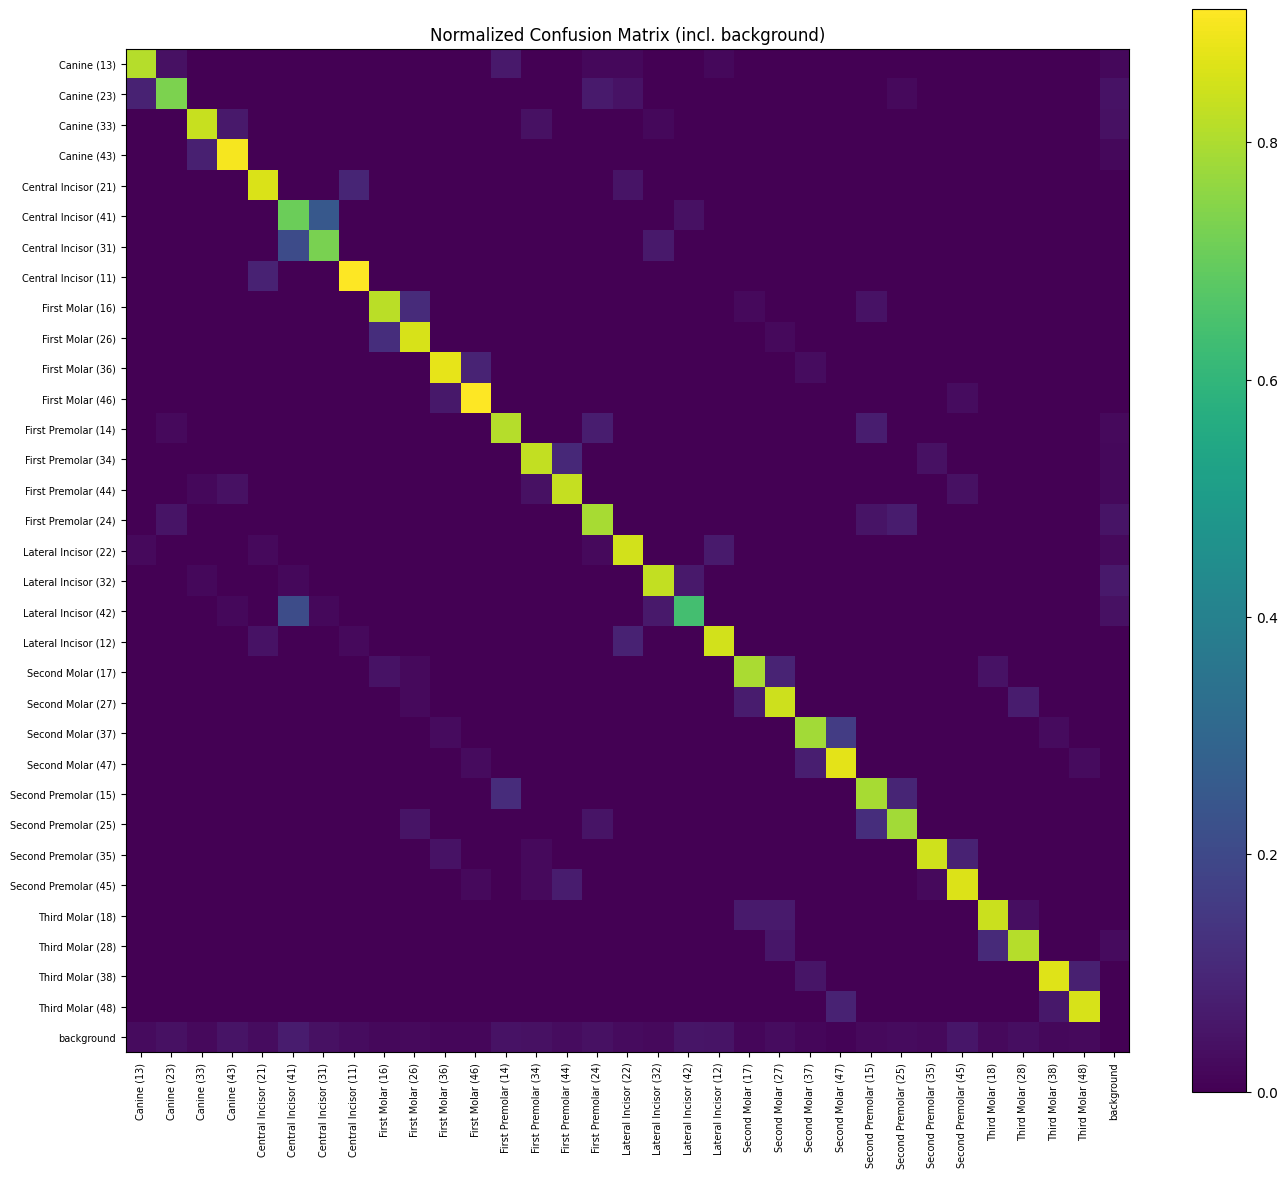

✅ Confusion matrix saved at /content/confusion_matrix.png


In [18]:
import os, glob, cv2, numpy as np
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load best trained model
MODEL_PATH = "runs/detect/oralvis_yolov8s/weights/best.pt"
model = YOLO(MODEL_PATH)

# Class names (exact order from data.yaml)
class_names = [
"Canine (13)","Canine (23)","Canine (33)","Canine (43)",
"Central Incisor (21)","Central Incisor (41)","Central Incisor (31)","Central Incisor (11)",
"First Molar (16)","First Molar (26)","First Molar (36)","First Molar (46)",
"First Premolar (14)","First Premolar (34)","First Premolar (44)","First Premolar (24)",
"Lateral Incisor (22)","Lateral Incisor (32)","Lateral Incisor (42)","Lateral Incisor (12)",
"Second Molar (17)","Second Molar (27)","Second Molar (37)","Second Molar (47)",
"Second Premolar (15)","Second Premolar (25)","Second Premolar (35)","Second Premolar (45)",
"Third Molar (18)","Third Molar (28)","Third Molar (38)","Third Molar (48)"
]

bg_class = len(class_names)  # "background" class for missed detections
val_images = sorted(glob.glob("/content/dataset/images/val/*"))

# Helper: IoU
def iou_xyxy(a,b):
    xa = max(a[0], b[0]); ya = max(a[1], b[1])
    xb = min(a[2], b[2]); yb = min(a[3], b[3])
    inter = max(0, xb-xa) * max(0, yb-ya)
    area_a = (a[2]-a[0])*(a[3]-a[1])
    area_b = (b[2]-b[0])*(b[3]-b[1])
    union = area_a + area_b - inter
    return inter/union if union>0 else 0

y_true, y_pred = [], []

# Loop over validation images
for img_path in val_images:
    img = cv2.imread(img_path)
    H,W = img.shape[:2]

    # Ground truth labels
    gt_file = os.path.splitext(img_path.replace("images","labels"))[0] + ".txt"
    gts = []
    if os.path.exists(gt_file):
        for line in open(gt_file):
            parts = line.strip().split()
            if len(parts) < 5: continue
            cls = int(float(parts[0])); cx,cy,w_rel,h_rel = map(float, parts[1:5])
            w_pix, h_pix = w_rel * W, h_rel * H
            x1 = (cx*W - w_pix/2); y1 = (cy*H - h_pix/2)
            x2 = x1 + w_pix; y2 = y1 + h_pix
            gts.append({'cls':cls, 'bbox':[x1,y1,x2,y2]})

    # Predictions
    results = model.predict(source=img_path, imgsz=640, conf=0.001, iou=0.5)
    res = results[0]
    preds=[]
    if hasattr(res,'boxes') and len(res.boxes)>0:
        xyxy = res.boxes.xyxy.cpu().numpy()
        cls = res.boxes.cls.cpu().numpy().astype(int)
        for box,c in zip(xyxy, cls):
            preds.append({'cls':int(c),'bbox':list(map(float,box))})

    # Match GTs to predictions
    matched=set()
    for gt in gts:
        best_j=-1; best_iou=0
        for j,p in enumerate(preds):
            if j in matched: continue
            i = iou_xyxy(gt['bbox'], p['bbox'])
            if i>best_iou:
                best_iou=i; best_j=j
        if best_iou>=0.5:
            y_true.append(gt['cls']); y_pred.append(preds[best_j]['cls'])
            matched.add(best_j)
        else:
            y_true.append(gt['cls']); y_pred.append(bg_class)  # missed

    # Unmatched preds = false positives
    for j,p in enumerate(preds):
        if j not in matched:
            y_true.append(bg_class); y_pred.append(p['cls'])

# Build confusion matrix
labels = list(range(len(class_names)+1))  # +1 for background
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot normalized confusion matrix
plt.figure(figsize=(14,12))
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
plt.imshow(cm_norm, interpolation='nearest')
plt.title("Normalized Confusion Matrix (incl. background)")
plt.colorbar()
tick_labels = class_names + ["background"]
plt.xticks(range(len(tick_labels)), tick_labels, rotation=90, fontsize=7)
plt.yticks(range(len(tick_labels)), tick_labels, fontsize=7)
plt.tight_layout()
plt.savefig("/content/confusion_matrix.png", dpi=200)
plt.show()

print("✅ Confusion matrix saved at /content/confusion_matrix.png")


In [19]:
import pandas as pd

# precision = TP / (TP + FP)
# recall = TP / (TP + FN)
# f1 = 2 * (prec*recall) / (prec+recall)

precisions = []
recalls = []
f1s = []
supports = []

for i, cls_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp

    prec = tp / (tp + fp + 1e-9)
    rec = tp / (tp + fn + 1e-9)
    f1 = 2 * prec * rec / (prec + rec + 1e-9)

    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    supports.append(cm[i, :].sum())

# Store results in DataFrame
df = pd.DataFrame({
    "Class": class_names,
    "Precision": np.round(precisions, 3),
    "Recall": np.round(recalls, 3),
    "F1-score": np.round(f1s, 3),
    "Support (#GT)": supports
})

# Save to CSV (for submission/report)
df.to_csv("/content/per_class_metrics.csv", index=False)

# Show top rows
df.head(10)


,Class,Precision,Recall,F1-score,Support (#GT)
0,Canine (13),0.437,0.809,0.567,47
1,Canine (23),0.324,0.733,0.449,45
2,Canine (33),0.506,0.837,0.631,49
3,Canine (43),0.355,0.898,0.509,49
4,Central Incisor (21),0.402,0.860,0.548,43
5,Central Incisor (41),0.205,0.708,0.318,48
6,Central Incisor (31),0.307,0.729,0.432,48
7,Central Incisor (11),0.427,0.911,0.582,45
8,First Molar (16),0.480,0.818,0.605,44
9,First Molar (26),0.456,0.857,0.595,42


In [22]:
!ls runs/detect/oralvis_yolov8s


args.yaml			 results.csv	      val_batch0_labels.jpg
BoxF1_curve.png			 results.png	      val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxPR_curve.png			 train_batch1.jpg     val_batch1_pred.jpg
BoxR_curve.png			 train_batch2.jpg     val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch3500.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch3501.jpg  weights
labels.jpg			 train_batch3502.jpg


In [23]:
!ls runs/detect/


oralvis_smoke_test  oralvis_yolov8s


In [25]:
import glob
from IPython.display import Image, display

# Get first 5 prediction images
pred_images = glob.glob("runs/detect/predict/*.jpg")[:5]

for img_path in pred_images:
    display(Image(filename=img_path))


In [26]:
!yolo detect predict model=runs/detect/oralvis_yolov8s/weights/best.pt source=/content/dataset/images/test save=True


Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs

image 1/51 /content/dataset/images/test/0ba65172-20240821-105924223.jpg: 640x640 2 Canine (23)s, 2 Canine (33)s, 1 Central Incisor (21), 2 Central Incisor (31)s, 1 Central Incisor (11), 3 First Molar (26)s, 2 First Molar (36)s, 1 First Molar (46), 2 First Premolar (34)s, 2 First Premolar (24)s, 1 Lateral Incisor (22), 1 Lateral Incisor (32), 1 Lateral Incisor (12), 3 Second Molar (27)s, 3 Second Molar (37)s, 2 Second Premolar (25)s, 2 Second Premolar (35)s, 1 Third Molar (28), 1 Third Molar (38), 16.3ms
image 2/51 /content/dataset/images/test/1c50bda9-20241231-145320490.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 2 Central Incisor (41)s, 1 Central Incisor (31), 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First Molar (46), 1 First

In [27]:
!ls runs/detect/


oralvis_smoke_test  oralvis_yolov8s  predict


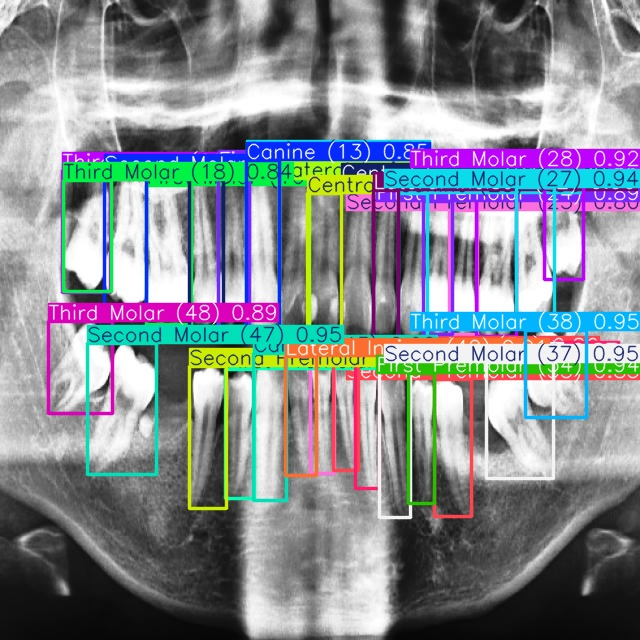

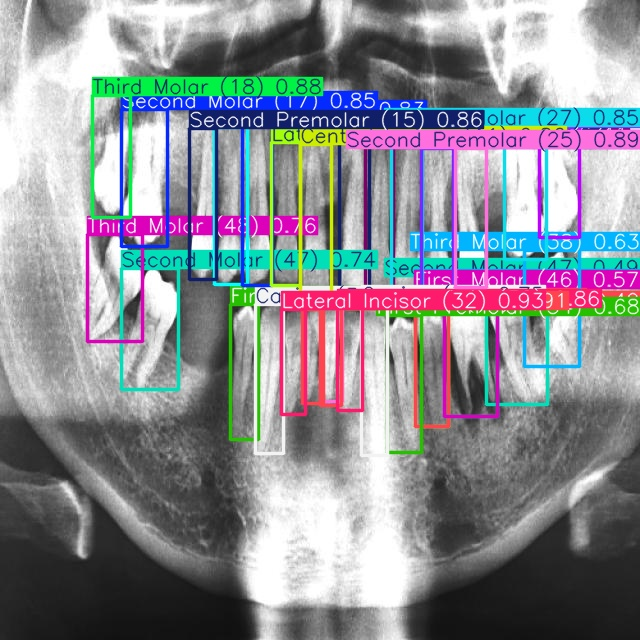

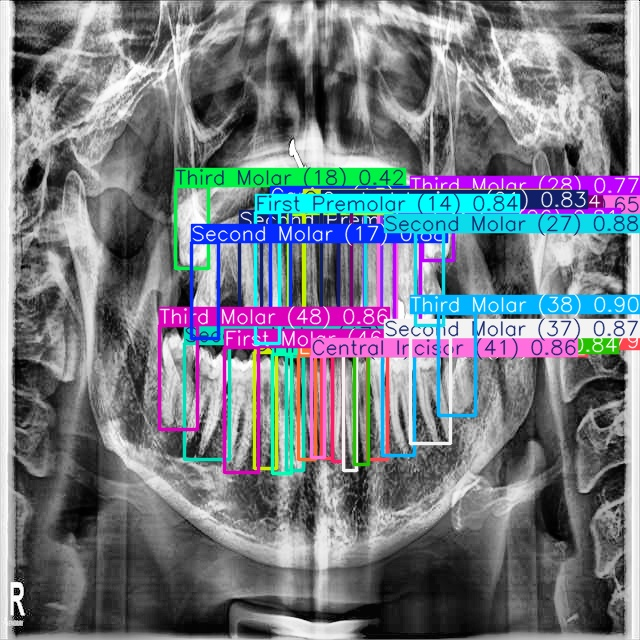

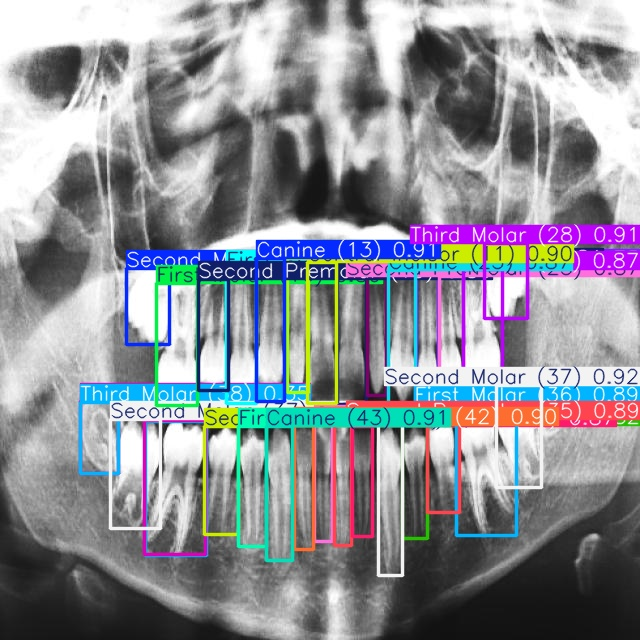

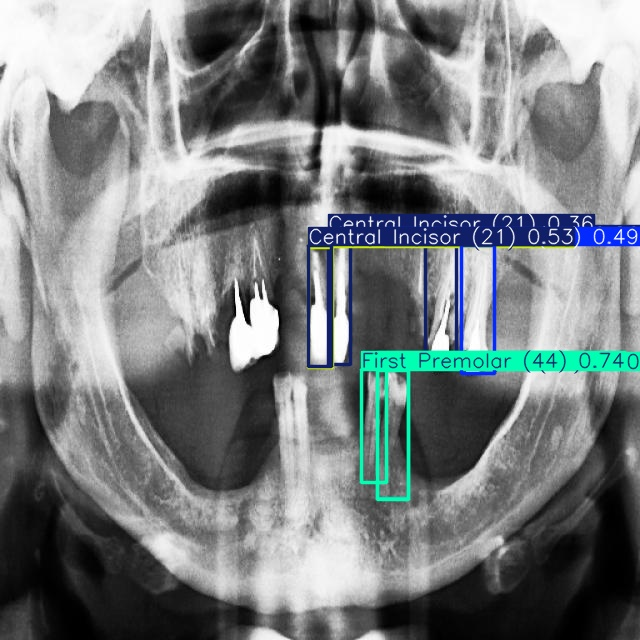

In [28]:
import glob
from IPython.display import Image, display

# Change 'predict' to 'predict2' if that is your folder
pred_images = glob.glob("runs/detect/predict/*.jpg")[:5]

for img_path in pred_images:
    display(Image(filename=img_path))
